In [3]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_provider import IBMProvider
import qiskit_ibm_provider.jupyter
 
#provider = IBMProvider('ibm-q')
#backend = provider.get_backend('ibmq_vigo')
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

qiskit_runtime_service.__init__:INFO:2024-03-08 11:54:28,833: Default instance: ibm-q/open/main


In [4]:
# Built-in modules
import math

# Imports from Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution

# Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Session

In [ ]:
# Add your token below
service = QiskitRuntimeService(channel="ibm_quantum")

In [5]:
from qiskit import IBMQ
IBMQ.save_account('33b329939cf6fe545c64afb41b84e0993a774c578c2d3e3a07b2ed8644261511d4712974c684ae3050ca82dd8f4ca161930bb344995de7934be32214bdb17079')

Traceback (most recent call last):
  Cell In[5], line 1
    from qiskit import IBMQ
ImportError: cannot import name 'IBMQ' from 'qiskit' (/opt/conda/lib/python3.10/site-packages/qiskit/__init__.py)

Use %tb to get the full traceback.


In [13]:
from qiskit.circuit import QuantumCircuit, Gate, Instruction
from qiskit.circuit.library.standard_gates import ZGate

def MCMT(gate, num_controls, num_targets):
    """Construct a multi-controlled multi-target gate.

    Args:
        gate (Gate): The gate to apply to the target qubits.
        num_controls (int): The number of control qubits.
        num_targets (int): The number of target qubits.

    Returns:
        Instruction: The multi-controlled multi-target gate as a Qiskit Instruction.
    """
    mcmt_gate = QuantumCircuit(num_controls + num_targets)
    mcmt_gate.append(gate.control(num_controls), list(range(num_controls + num_targets)))
    return mcmt_gate.to_instruction()

In [14]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.rx(0.1,zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

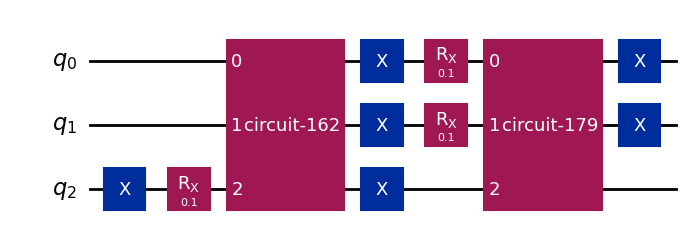

In [15]:
marked_states = ["011", "100"]

oracle = grover_oracle(marked_states)
oracle.draw("mpl")

In [16]:
grover_op = GroverOperator(oracle)
grover_op.decompose().draw("mpl")

Traceback (most recent call last):
  Cell In[16], line 1
    grover_op = GroverOperator(oracle)
NameError: name 'GroverOperator' is not defined

Use %tb to get the full traceback.


In [8]:
optimal_num_iterations = math.floor(
    math.pi / 4 * math.sqrt(2**grover_op.num_qubits / len(marked_states))
)

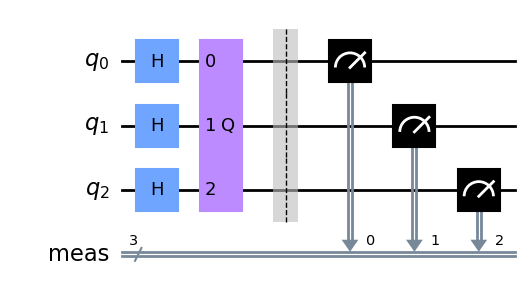

In [9]:
qc = QuantumCircuit(grover_op.num_qubits)
# Create even superposition of all basis states
qc.h(range(grover_op.num_qubits))
# Apply Grover operator the optimal number of times
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
# Measure all qubits
qc.measure_all()
qc.draw("mpl")

In [10]:
# Select the simulator with the fewest number of jobs in the queue
backend_simulator = service.least_busy(simulator=True, operational=True)
backend_simulator.name

'simulator_extended_stabilizer'

In [11]:
# Initialize your session
sim_session = Session(backend=backend_simulator)
sim_sampler = Sampler(session=sim_session)

In [12]:
sim_dist = sim_sampler.run(qc, shots=int(1e4)).result().quasi_dists[0]

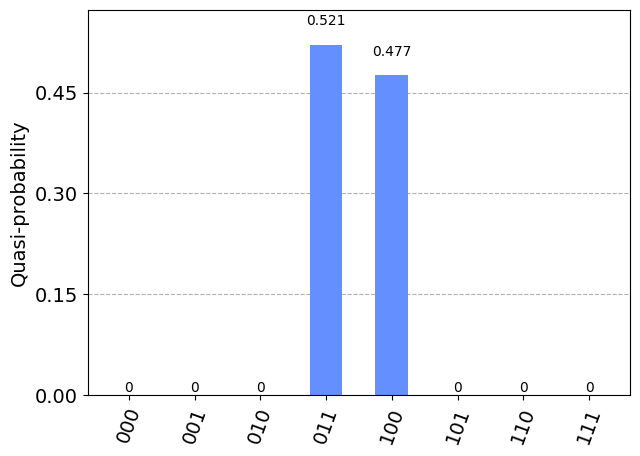

In [13]:
plot_distribution(sim_dist.binary_probabilities())

In [15]:
sim_session.close()

In [16]:
# Select the backend with the fewest number of jobs in the queue
backend = service.least_busy(simulator=False, operational=True)
backend.name

'ibmq_jakarta'

In [17]:
# Initialize your session
session = Session(backend=backend)

real_sampler = Sampler(session=session)

In [18]:
real_dist = real_sampler.run(qc, shots=int(1e4)).result().quasi_dists[0]

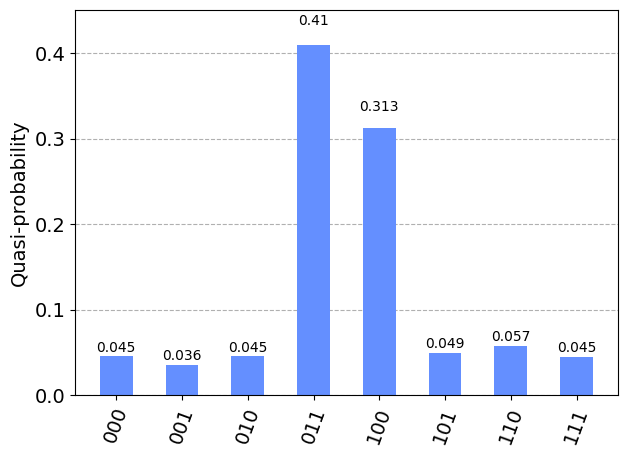

In [19]:
plot_distribution(real_dist.binary_probabilities())

In [20]:
# Close session
session.close()